In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


In [24]:
class StationaryBandit:
    def __init__(self, k = 10, epsilon = 0., initial = 0.,true_value = 0., s_size = 0., variance = 1., UCB_parameter = 0., variable_epsilon = False, baseline = False, gradient_bandit = False, Stationary = True):
        self.k_arm = k       #number of arms
        self.e = epsilon     # (the greater the epsilon, the higher the exploration) 
        self.indices = np.arange(k) #creating an array from 0 to 9 to assign indices to the k arms later.
        self.true_reward = true_value #true value
        self.step_size = s_size       #step size for each update rule of the estimate
        self.average_reward = 0
        self.time = 0
        self.initial_estimate = initial  #initial value of the reward estimate is initialized, default = 0.
        self.variance = variance
        #Parameters for UCB
        self.UCB_parameter = UCB_parameter # for UCB part --> c , UCB parameter
        self.UCB_estimation = np.zeros(self.k_arm) # initializing the USB estimation.
        self.variable_epsilon = variable_epsilon
        #Parameters for Gradient Bandit
        self.gradient_baseline = baseline
        self.gradient = gradient_bandit
        self.baseline = 0
        self.action_probabilities = 0
        #adding stationary boolean for part 5 where independent walks are made for non stationary.
        self.stationary = Stationary
        
    def reset(self):
        self.UCB_estimation = np.zeros(self.k_arm)
        self.q_true = np.random.randn(self.k_arm)+ self.true_reward
        self.q_estimate = np.zeros(self.k_arm) + self.initial_estimate
        self.action_count = np.zeros(self.k_arm) #the number of times all actions are chosen reset to zero.
        self.greedy_action = np.argmax(self.q_true)
        self.time = 0
        if(self.variable_epsilon == True):
            self.e = 1/(self.time+1)
    
    def act(self): #--> returns a function.\if(self.variable_epsilon):
        if(self.variable_epsilon):
            self.e = 1/(self.time+1)
        if np.random.rand() < self.e: #randomly choosing any action
            return np.random.choice(self.indices)
        if(self.UCB_parameter!=0):
            self.UCB_estimation = (self.q_estimate + self.UCB_parameter * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5)))
            q_best = np.max(self.UCB_estimation)
            return np.random.choice(np.where(self.UCB_estimation == q_best)[0])
        elif(self.gradient==True):
            exp = np.exp(self.q_estimate)
            self.action_probabilities = exp / np.sum(exp)
            return np.random.choice(self.indices, p=self.action_probabilities)
        else:
            q_best = np.max(self.q_estimate) #else choose argmax.
            return np.random.choice(np.where(self.q_estimate == q_best)[0])
        
    def step(self, action): #--> function : takes action, returns a reward.
        #function at each step
        
        self.time +=1 #updating time step
        reward = np.random.randn() + self.q_true[action]
        self.action_count[action] +=1 #updating the number of times action is chosen in action_count array.
        self.average_reward += (reward - self.average_reward) / self.time
        if(self.stationary==False):
            for i in range(len(self.q_estimate)):
                self.q_estimate[i] += np.random.normal(scale = 0.1)
        if(self.gradient):
            one_hot = np.zeros(self.k_arm)
            one_hot[action] = 1
            if(self.gradient_baseline):
                self.baseline = self.average_reward
            else:
                self.baseline = 0
            self.q_estimate += self.step_size * (reward - self.baseline) * (one_hot - self.action_probabilities)
        else:
            
            if(self.variance == 1.0):
                reward = np.random.randn() + self.q_true[action]
            else:
                reward = np.random.normal(scale = 2.0)+ self.q_true[action]
            n = self.action_count[action]
            
            self.q_estimate[action] += (reward-self.q_estimate[action])/n #updating the q_estimate
        return reward
        
        
        
        

In [10]:
def run_experiment(bandits, runs, time):
    rewards = np.zeros((len(bandits),runs, time))
    best_action_counts  = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in range(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i,r,t] = reward
                if(action==bandit.greedy_action):
                    best_action_counts[i,r,t] = 1
    mean_best_action_counts = best_action_counts.mean(axis = 1)
    mean_rewards = rewards.mean(axis = 1)
    return mean_best_action_counts, mean_rewards

Q3: Continually performing explorations allowed the e-greedy methods to better identify the optimal action. The e = 0.1 method explored more, and usually found the optimal action earlier, but it never selected that action more than 91% of the time. The e = 0.01 method improved more slowly in the beginning but over the long run it performs better than e = 0.01.
The cumulative reward for an e-greedy method in a long time is given by the following equation:
(1-e + e/|a|) ( max $\underset{a}$ phi*(a) + $\sum\limits_{a ≠ a*}$ e/|a| . phi*(a) ) 
Over a long time, |a| will be large which will tend e/|a| to 0. This overall term increases for e = 0.01 more than e = 0.1 as the time progresses and |a| increases.

Q1:i) Generating plots in figure 2.2:

In [11]:
r = 2000
t = 1000
bandits = [StationaryBandit(epsilon = e) for e in [0,0.1,0.01]]
best_action_counts, rewards = run_experiment(bandits,r,t)


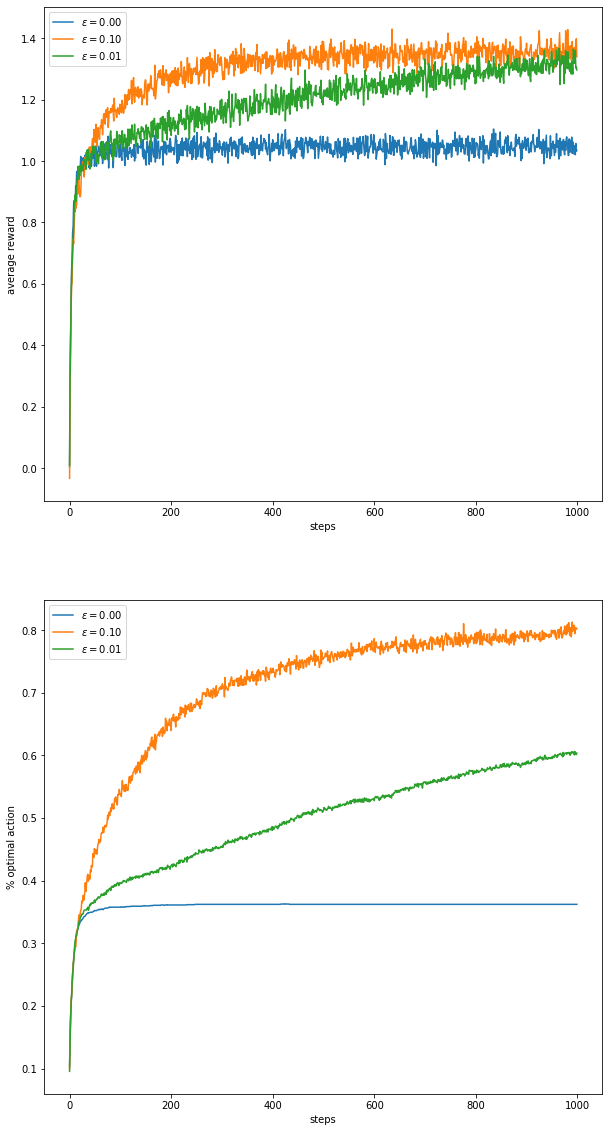

In [12]:
plt.figure(figsize=(10, 20))
plt.subplot(2,1,1)
for eps, rewards in zip([0, 0.1, 0.01], rewards):
    plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()
plt.subplot(2, 1, 2)
for eps, counts in zip([0,0.1, 0.01], best_action_counts):
    plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
plt.show()


Q1. ii) Generating plot for average absolute error:

In [ ]:
runs = 2000
time  = 1000
rewards = np.zeros((len(bandits),runs, time))
absolute_error = np.zeros(rewards.shape)
for i, bandit in enumerate(bandits):
        for r in range(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i,r,t] = reward
                if(action==bandit.greedy_action):
                    absolute_error[i,r,t] = np.abs(bandit.q_true[action]- bandit.q_estimate[action])
mean_absolute_error = absolute_error.mean(axis = 1)


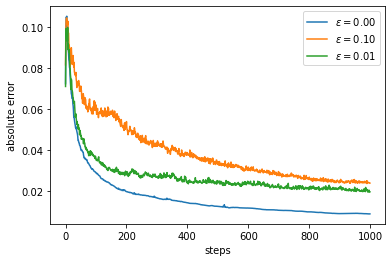

In [21]:

for eps, counts in zip([0,0.1, 0.01], mean_absolute_error):
    plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('absolute error')
    plt.legend()
plt.show()

Q2. Repeat Question 1 with variance 4.

In [ ]:
r = 2000
t = 1000
bandits2 = [StationaryBandit(epsilon = e, variance = 4) for e in [0,0.1,0.01]]
best_action_counts2, rewards2 = run_experiment(bandits2,r,t)

In [ ]:
plt.figure(figsize=(10, 20))
plt.subplot(2,1,1)
for eps, rewards in zip([0, 0.1, 0.01], rewards2):
    plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()
plt.subplot(2, 1, 2)
for eps, counts in zip([0,0.1, 0.01], best_action_counts2):
    plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
plt.show()

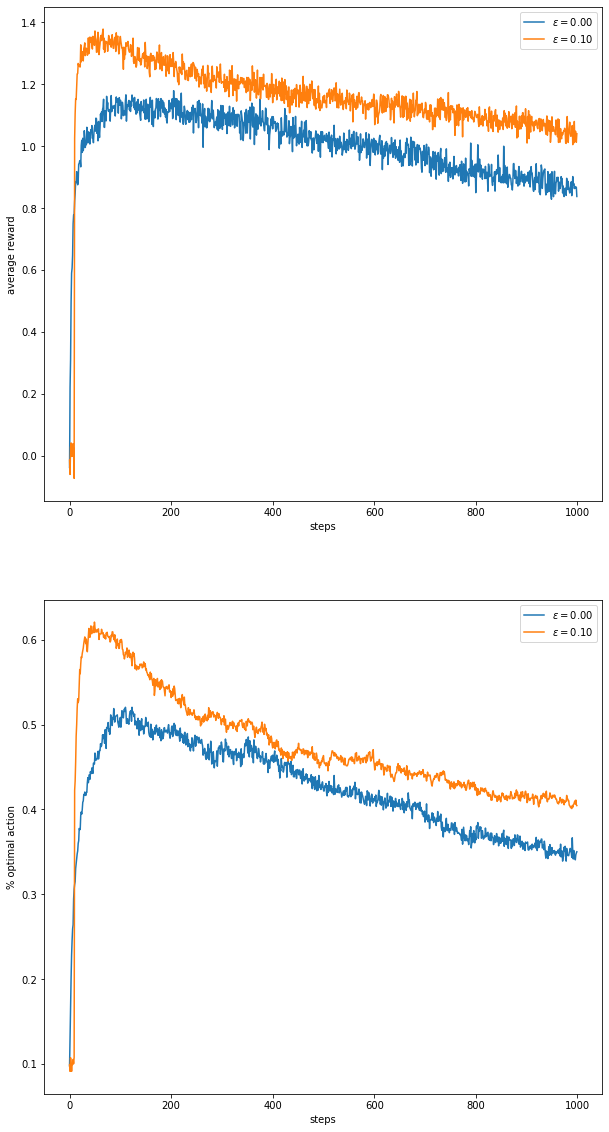

In [26]:
r = 2000
t = 1000
walks = [StationaryBandit(epsilon = 0.1, Stationary= False), StationaryBandit(UCB_parameter = 0.1, Stationary = False)]
best_action_counts_walks , rewards_walks = run_experiment(walks, r, t)
plt.figure(figsize=(10, 20))
plt.subplot(2,1,1)
for eps, rewards in zip([0, 0.1, 0.01], rewards_walks):
    plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()
plt.subplot(2, 1, 2)
for eps, counts in zip([0,0.1, 0.01], best_action_counts_walks):
    plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
plt.show()

In [ ]:
r = 2000
t = 1000
bandits3 = [StationaryBandit(epsilon = 0., UCB_parameter = 2), StationaryBandit(epsilon = 0.1)]
best_action_counts3, rewards3 = run_experiment(bandits3,r,t)


In [ ]:
plt.figure(figsize=(10, 20))
plt.subplot(2,1,1)
for eps, rewards in zip([0, 0.1], rewards3):
    plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()
plt.show()

Q.6: Generating Figure 2.4 below:
Explanation for spike:There is a lot of exploration in the first ten steps. since the action is chosen quite a few times[N(a) increases], the UCB uses this to start exploiting more.

In [ ]:
ucbs = [StationaryBandit(UCB_parameter = 1), StationaryBandit(UCB_parameter = 4)]
best_action_counts_ucbs, rewards_ucbs = run_experiment(ucbs, r, t)

In [ ]:
plt.figure(figsize=(10, 20))
plt.subplot(2,1,1)
for eps, rewards in zip([0, 0.1], rewards_ucbs):
    plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()
plt.show()


Q1. The part with variable epsilon: {e = 1/t} satisfies the mentioned conditions and that has been chosen for the Stationary Bandit objects below.

In [ ]:
bandit4 = [StationaryBandit(variable_epsilon = True), StationaryBandit( epsilon = 0.1) , StationaryBandit(epsilon = 0.01), StationaryBandit(epsilon  = 0.0) ]
best_action_count_variable, rewards_variable = run_experiment(bandit4, 2000, 1000)

In [ ]:
plt.figure(figsize=(10, 20))
plt.subplot(2,1,1)

for eps, rewards in zip([1, 0.1, 0.01, 0.0], rewards_variable):
    if(eps ==1):
        plt.plot(rewards_variable[0], label='$\epsilon = 1/n$')
    else:
        plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))

plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()
plt.show()
plt.subplot(2, 1, 2)
for eps, counts in zip([1,0.1,0.01, 0.0], best_action_count_variable):
    if(eps ==1):
        plt.plot(best_action_count_variable[0], label='$\epsilon = 1/n$')
    else:
        plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
plt.show()

Q7. Generating Figure 2.5

In [ ]:
gradient_bandits = [StationaryBandit(s_size = alpha, gradient_bandit = True, baseline = k) for alpha in [0.1, 0.4] for k in [True, False]]
gradient_bandit_counts, gradient_bandit_rewards = run_experiment(gradient_bandits, 2000,1000)


In [ ]:
plt.figure(figsize=(10, 20))
plt.plot(gradient_bandit_counts[0], label = 'alpha = 0.4 with baseline')
plt.plot(gradient_bandit_counts[1], label = 'alpha = 0.1 without baseline')
plt.plot(gradient_bandit_counts[2], label = 'alpha = 0.1 with baseline')
plt.plot(gradient_bandit_counts[3], label = 'alpha = 0.4 without baseline')
plt.xlabel('steps')
plt.ylabel('Optimal Action')
plt.legend()
plt.show()

In [ ]:
class UCB:
    def __init__(self, k = 10, epsilon = 0., initial = 0.,true_value = 0., s_size = 0., c = 0. ):
        self.k_arm = k       #number of arms
        self.e = epsilon     # (the greater the epsilon, the higher the exploration) 
        self.indices = np.arange(k) #creating an array from 0 to 9 to assign indices to the k arms later.
        self.true_reward = true_value #true value
        self.step_size = s_size       #step size for each update rule of the estimate
        self.average_reward = 0
        self.time = 0
        self.initial_estimate = initial  #initial value of the reward estimate is initialized, default = 0.
        self.UCB_parameter = c
        
    def reset(self):
        self.q_true = np.random.randn(self.k_arm)+ self.true_reward
        self.q_estimate = np.zeros(self.k_arm) + self.initial_estimate
        self.action_count = np.zeros(self.k_arm) #the number of times all actions are chosen reset to zero.
        self.greedy_action = np.argmax(self.q_true)
        self.time = 0
    
    def act(self): #--> returns a function.
        if np.random.rand() < self.e: #randomly choosing any action
            return np.random.choice(self.indices)
        UCB_estimate = self.q_estimate + self.UCB_parameter* np.sqrt(np.log(self.time+1)/self.action_count) #else choose argmax.
        return np.random.choice(np.where(UCB_estimate == q_best)[0])
        
    def step(self, action): #--> function : takes action, returns a reward.
        #function at each step
        self.time +=1 #updating time step
        self.action_count[action] +=1 #updating the number of times action is chosen in action_count array.
        reward = np.random.randn() + self.q_true[action]
        n = self.action_count[action]
        self.average_reward += (reward - self.average_reward) / self.time
        self.q_estimate[action] += (reward-self.q_estimate[action])/n #updating the q_estimate
        return reward